### 0.0 load in some helpful packages

In [47]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter, WeekdayLocator, DayLocator

%matplotlib inline

### 0.1 Load the data

#### Context
- Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in Seattle, WA.

#### Content
- The following Airbnb activity is included in this Seattle dataset: 
- * Listings, including full descriptions and average review score 
- * Reviews, including unique id for each reviewer and detailed comments 
- * Calendar, including listing id and the price and availability for that day

### Part I. Calendar

In [66]:
calendar_seattle = pd.read_csv(".\seattle\calendar.csv")
print(calendar_seattle.shape)
calendar_seattle.head()

(1393570, 4)


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [67]:
calendar_boston = pd.read_csv(".\\boston\\calendar.csv")
print(calendar_boston.shape)
calendar_boston.head()

(1308890, 4)


,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


#### 1.2 clean the data

In [59]:
def replace_x(x):
    try:
        x = x.replace('$','')
    except:
        pass
    try:
        x = x.replace(',','')
    except:
        pass
    return float(x)
x = "$850,500.00"
replace_x(x)

850500.0

In [72]:
def get_avg_price(df):
    df = df[(df.available=="t")]
    df = df[["date","price"]]
    df["price"]=df["price"].apply(replace_x)
    df = df.groupby(["date"]).mean()
    return df
seattle_avg_price = get_avg_price(calendar_seattle)
boston_avg_price = get_avg_price(calendar_boston)

#### 1.3 analyze

In [76]:
seattle_avg_price.rename(columns={"price":"seattle_avg_prices"},inplace=True)
boston_avg_price.rename(columns={"price":"boston_avg_prices"},inplace=True)
avg_prices = seattle_avg_price.join(boston_avg_price,how="outer")
print(avg_prices.shape)
avg_prices.head()

(611, 2)


,seattle_avg_prices,boston_avg_prices
date,,
2016-01-04,122.085879,NaN
2016-01-05,120.681307,NaN
2016-01-06,120.928258,NaN
2016-01-07,120.958896,NaN
2016-01-08,127.640853,NaN


In [82]:
seattle_avg_p = avg_prices.seattle_avg_prices.mean()
boston_avg_p = avg_prices.boston_avg_prices.mean()
print("The average price in seattle was $",int(seattle_avg_p), "The average price in boston was $",int(boston_avg_p), 
      "The average price in boston was higher than seattle with about $",int(boston_avg_p-seattle_avg_p))

The average price in seattle was $ 137 The average price in boston was $ 201 The average price in boston was higher than seattle with about $ 63


#### 1.4 visualize 

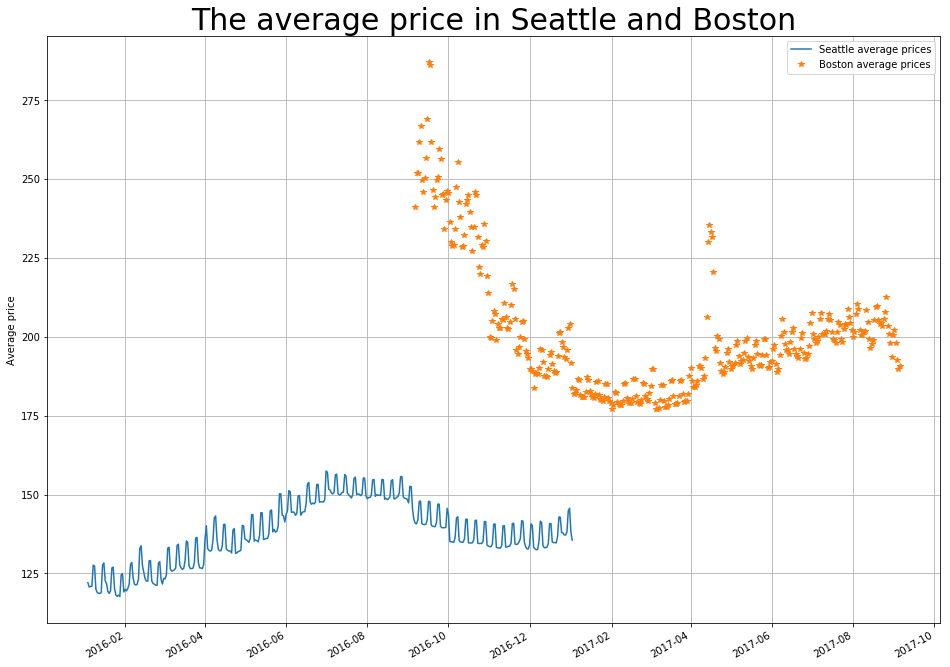

In [89]:
dates = pd.to_datetime(avg_prices.index.values, errors ="ignore")

fig, axs = plt.subplots(1,1)
axs.plot_date(dates, avg_prices.seattle_avg_prices.tolist(),"-",label="Seattle average prices")
axs.plot_date(dates, avg_prices.boston_avg_prices.tolist(),"*",label="Boston average prices")
axs.autoscale_view()
axs.fmt_xdata = DateFormatter("%Y-%m-%d")
axs.grid(True)
axs.set_ylabel("Average price")
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, labels)
fig.adjustable = True
fig.set_size_inches(16,12)
fig.autofmt_xdate()
plt.title("The average price in Seattle and Boston",fontsize=30)
plt.show()

### Q1. Comparing the trend of  prices in Boston and Seattle; Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?
### Answer:
- (1) The average price in seattle was  137 dollars. The average price in boston was  201 dollars. The average price in boston was higher than seattle with about  63 dollars.
- (2) Prices in both cities were rising from February to August and falling from September to February.

### Q2. What are the busiest times of the year to visit Seattle? By how much do prices spike?
### Answer:
- The busiest times of the year to visit Seattle are July and September.
- Accommodation prices rose by about 30 dollars compared with the minimum prices.

### Part II. Listings 
- Let's look at the differences between the words used in listings for Airbnb locations in different Seattle neighborhoods

In [91]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from nltk import wordpunct_tokenize          
from nltk.stem import WordNetLemmatizer

### Function and class definitions

In [92]:
class LemmaTokenizer(object):
    """Custom tokenizer class that stems tokens"""
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in wordpunct_tokenize(doc) if len(t.strip()) > 1]
    
def show_topn(classifier, vectorizer, categories, n):
    """Returns the top n features that characterize each category"""
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        topn = np.argsort(classifier.coef_[i])[-n:] #argsort sorts in asc order
        print('{}: {}'.format(category, ", ".join(feature_names[topn])))

In [93]:
listings = pd.read_csv(".\seattle\listings.csv" ,usecols = ['id', 'name', 'space', 'description', 'neighborhood_overview', 'neighbourhood_cleansed'])
print(listings.shape)
listings.head()

(3818, 6)


,id,name,space,description,neighborhood_overview,neighbourhood_cleansed
0,241032,Stylish Queen Anne Apartment,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,West Queen Anne
1,953595,Bright & Airy Queen Anne Apartment,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...",West Queen Anne
2,3308979,New Modern House-Amazing water view,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,West Queen Anne
3,7421966,Queen Anne Chateau,NaN,A charming apartment that sits atop Queen Anne...,NaN,West Queen Anne
4,278830,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,We are in the beautiful neighborhood of Queen ...,West Queen Anne


#### let's combine the name, space, description, and neighborhood_overview into a new column 

In [95]:
listings['combined_description'] = listings.apply(lambda x: '{} {} {} {}'.format(x['name'], x['space'], x['description'], x['neighborhood_overview']), axis=1)

### Q3. How many listings are there for each neighborhood?

In [96]:
listings.groupby(by="neighbourhood_cleansed").count()[["id"]].sort_values(by="id",ascending=False)

,id
neighbourhood_cleansed,
Broadway,397
Belltown,234
Wallingford,167
Fremont,158
Minor,135
University District,122
Stevens,119
First Hill,108
Central Business District,103


In [102]:
pipeline = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2), stop_words='english', tokenizer=LemmaTokenizer())),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, n_iter=5, random_state=42)),
])


le = LabelEncoder()
new_target = le.fit_transform(listings['neighbourhood_cleansed'])
model = pipeline.fit(listings['combined_description'], new_target)

D:\Anaconda\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


### Answer:  Our model choose Top five phrases that characterize each neighborhood
- Show the top 5 phrases that characterize each neighborhood

In [103]:
show_topn(model.named_steps['clf'], model.named_steps['tfidf'], le.inverse_transform(model.named_steps['clf'].classes_), 5)

Adams: ballard ha, plum, lock, heart ballard, ballard
Alki: beach bedroom, water, alki beach, beach, alki
Arbor Heights: yard bathroom, beach super, treehouse yard, treehouse, playroom
Atlantic: chinatown, self check, atlantic, international, international district
Belltown: vacation rental, heart belltown, vacation, belltown neighborhood, belltown
Bitter Lake: bathroom nearly, spencer, shared, dedicated, shared just
Briarcliff: block magnolia, discovery park, discovery, adu, magnolia
Brighton: link rail, new sheet, light link, serene room, right light
Broadview: older quiet, home older, broadview, carkeek park, carkeek
Broadway: heart capitol, hill, capitol hill, capitol, broadway
Bryant: child, hospital, away burke, child hospital, bryant
Cedar Park: excuse, mess picture, 16 unit, condo 16, mn
Central Business District: pike place, step, step property, harbor, harbor step
Columbia City: light rail, heart columbia, city, columbia, columbia city
Crown Hill: north, greenwood neighborhoo

### Part III. reviews
- Sentiment Analysis and Collocation of Reviews
- In this notebook we apply sentiment analysis to the reviews for the Boston-area AirBnBs in our dataset.

In [105]:
reviews = pd.read_csv("./boston/reviews.csv")
print(reviews.shape)
reviews.head()

(68275, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [106]:
listings = pd.read_csv("./boston/listings.csv")
print(listings.shape)
listings.head()

(3585, 95)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


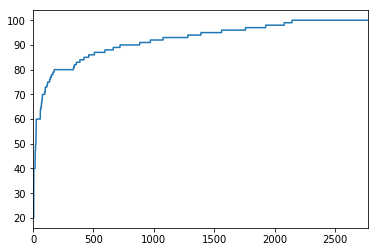

In [107]:
listings["review_scores_rating"].sort_values().reset_index(drop=True).dropna().plot()

#### First we note the highly skewed distribution of reviews on the Internet: many many positives, not many negatives. This holds just as true on AirBnB as everywhere else. 

In [110]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
for sentence in reviews["comments"].values[:5]:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        print("{0} :{1}".format(k, ss[k]),end="")
        print()

My stay at islam's place was really cool! Good location, 5min away from subway, then 10min from downtown. The room was nice, all place was clean. Islam managed pretty well our arrival, even if it was last minute ;) i do recommand this place to any airbnb user :)
compound :0.9626
neg :0.0
neu :0.648
pos :0.352
Great location for both airport and city - great amenities in the house: Plus Islam was always very helpful even though he was away
compound :0.9061
neg :0.0
neu :0.639
pos :0.361
We really enjoyed our stay at Islams house. From the outside the house didn't look so inviting but the inside was very nice! Even though Islam himself was not there everything was prepared for our arrival. The airport T Station is only a 5-10 min walk away. The only little issue was that all the people in the house had to share one bathroom. But it was not really a problem and it worked out fine. We would recommend Islams place for a stay in Boston. 
compound :0.9663
neg :0.0
neu :0.767
pos :0.233
The ro

In [111]:
from nltk.corpus import stopwords   # stopwords to detect language
from nltk import wordpunct_tokenize # function to split up our words

def get_language_likelihood(input_text):
    """Return a dictionary of languages and their likelihood of being the 
    natural language of the input text
    """
 
    input_text = input_text.lower()
    input_words = wordpunct_tokenize(input_text)
 
    language_likelihood = {}
    total_matches = 0
    for language in stopwords._fileids:
        language_likelihood[language] = len(set(input_words) &
                set(stopwords.words(language)))
 
    return language_likelihood
 
def get_language(input_text):
    """Return the most likely language of the given text
    """ 
    likelihoods = get_language_likelihood(input_text)
    return sorted(likelihoods, key=likelihoods.get, reverse=True)[0]

In [113]:
reviews_f = [r for r in reviews['comments'] if pd.notnull(r) and get_language(r) == 'english']

### Generate our sentiment scores

In [114]:
pscores =[sid.polarity_scores(comment) for comment in reviews_f]

### Q4 How do we score on diffenent sentiments?

#### Neutrality
- The scores present normal distribution. The mean of the scores is between 0.7 and 0.8.

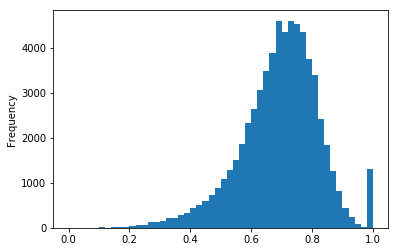

In [116]:
pd.Series([score["neu"] for score in pscores]).plot(kind = "hist",bins = 50)

#### Positivity 
- The scores present normal distribution. The mean of the scores is between 0.2 and 0.4.

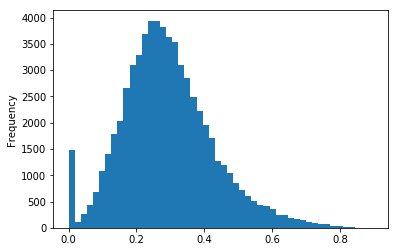

In [117]:
pd.Series([score["pos"] for score in pscores]).plot(kind = "hist",bins=50)

#### Negativity 
- A significant amount of them are given exactly 0.0 negativity.

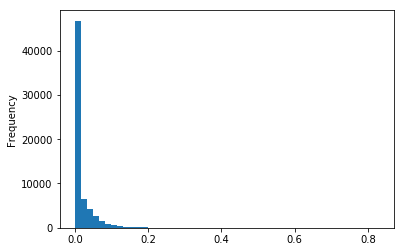

In [118]:
pd.Series([score["neg"] for score in pscores]).plot(kind="hist", bins =50)

In [119]:
scored_reviews = pd.DataFrame()
scored_reviews['review'] = [r for r in reviews_f if get_language(r) == 'english']
scored_reviews['compound'] = [score['compound'] for score in pscores]
scored_reviews['negativity'] = [score['neg'] for score in pscores]
scored_reviews['neutrality'] = [score['neu'] for score in pscores]
scored_reviews['positivity'] = [score['pos'] for score in pscores]

In [120]:
scored_reviews.head()

,review,compound,negativity,neutrality,positivity
0,My stay at islam's place was really cool! Good...,0.9626,0.0,0.648,0.352
1,Great location for both airport and city - gre...,0.9061,0.0,0.639,0.361
2,We really enjoyed our stay at Islams house. Fr...,0.9663,0.0,0.767,0.233
3,The room was nice and clean and so were the co...,0.9267,0.0,0.673,0.327
4,Great location. Just 5 mins walk from the Airp...,0.8658,0.0,0.637,0.363


#### Let's see some negativity.

In [123]:
scored_reviews.query('negativity > positivity').query('negativity > 0.2').head()

,review,compound,negativity,neutrality,positivity
16,Izzy was great... had clear instructions and n...,-0.6802,0.344,0.546,0.109
61,Parking situation was bad. Very hard to find ...,-0.2982,0.226,0.622,0.152
463,Good experience. Parking was a bit tricky; ot...,-0.3818,0.451,0.347,0.201
517,"Good experience, no main complaints except had...",-0.2500,0.331,0.473,0.196
521,The apartment was disappointing compared to th...,-0.9260,0.273,0.727,0.000


In [122]:
scored_reviews.query('negativity > positivity').query('compound < -0.5').head()

,review,compound,negativity,neutrality,positivity
16,Izzy was great... had clear instructions and n...,-0.6802,0.344,0.546,0.109
23,We didn´t meet Izzy at all!!!! After we arrive...,-0.7798,0.138,0.787,0.075
198,nothing what I expected !\nwe start from the p...,-0.9528,0.187,0.756,0.057
452,The listing is accurate. This is a no frills k...,-0.7184,0.196,0.773,0.030
465,We were rather disappointed with this accommod...,-0.5575,0.123,0.789,0.088


In [125]:
scored_reviews.iloc[198]["review"]

'nothing what I expected !\nwe start from the position..the house is in a very bad boston district where there is nothing and there live exclusively Latinos (hispanic district) ! the metro is a 10 min walk but if you come back late at night you have to go for strength to a park where there are not recommended subjects . we had always come back soon because we were afraid something happened to us ! neighborhood dirty, ugly people , no restaurant !\nas it regards the room was in the basement ... with a small WC designed in under 1 meter scale .\nall very dirty and very poorly maintained.\nnobody helped us by giving us indications\nterrible experience .'

#### Let's see some positivity 

In [126]:
scored_reviews.query('negativity < positivity').query('compound > 0.5').head()

,review,compound,negativity,neutrality,positivity
0,My stay at islam's place was really cool! Good...,0.9626,0.0,0.648,0.352
1,Great location for both airport and city - gre...,0.9061,0.0,0.639,0.361
2,We really enjoyed our stay at Islams house. Fr...,0.9663,0.0,0.767,0.233
3,The room was nice and clean and so were the co...,0.9267,0.0,0.673,0.327
4,Great location. Just 5 mins walk from the Airp...,0.8658,0.0,0.637,0.363


In [127]:
scored_reviews.iloc[4]["review"]

'Great location. Just 5 mins walk from the Airport Station. Good food nearby.\r\nRoom was simple, clean, just what I was after.'